In [1]:
# import packages
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as sp
%load_ext google.cloud.bigquery
import pickle
from matplotlib import pyplot as plt
from datetime import datetime
with open('design.pkl','rb') as f:
    set_params = pickle.load(f)
plt.rcParams.update(set_params)

from google.cloud import bigquery

In [2]:

# Modules
from modules.connector import MyBigQuery, MySQL

In [3]:
bq = MyBigQuery(
    credentials_file="./credentials/New AutoMotive Index-487e031dc242.json"
)

In [4]:
def ft_cleaner(x):
    x = x.replace('GAS BI-FUEL', 'Other').replace('GAS', 'Other').replace('GAS DIESEL', 'Other').replace('PETROL/GAS', 'Other').replace('LPG', 'Other').replace('STEAM', 'Other').replace('LNG', 'Other').replace('OTHER', 'Other').replace('CNG', 'Other')
    x = x.replace('FUEL CELLS', 'Other')
    x = x.replace('PETROL', 'Petrol').replace('Petrol/Other', 'Petrol')
    x = x.replace('HYBRID ELECTRIC (CLEAN)', 'Hybrid').replace('HYBRID ELECTRIC', 'Hybrid').replace('ELECTRIC DIESEL', 'Hybrid')
    x = x.replace('DIESEL', 'Diesel').replace('Other Diesel', 'Diesel')
    x = x.replace('ELECTRICITY', 'Pure Electric').replace('ELECTRIC', 'Pure Electric')
    return x

In [14]:
# co2ComplianceAdj will be the surplus after removing demand from other manufacturers
def co2ComplianceAdjFunc(row, total_trading_diff_perc):
    #checks for nan
    if row.co2Compliance > 0:
        co2ComplianceAdj = row.co2Compliance * total_trading_diff_perc
    
        return co2ComplianceAdj
    else:
        return row.co2Compliance


    
def co2_to_zev(row, mandate):
    new_zev_credits = 0
    limit = mandate*.25
    limit = limit * row.totalSales
    
    if row.co2Compliance > 0:
        new_zev_credits = row.co2ComplianceAdj / 167
    
    if new_zev_credits > limit:
        new_zev_credits = limit
        
    
    if new_zev_credits > 0:
        return new_zev_credits
    else:
        return 0

# Latest Compliance

In [5]:
this_month = datetime.today().strftime(format='%Y-%m')

In [6]:
first_of_current_month = this_month+'-01'
first_of_current_month

'2023-07-01'

In [7]:
datetime.today().month

7

In [8]:
last_month = datetime.today().replace(month=datetime.today().month-1).strftime(format='%Y-%m')

In [9]:
mandate =.22

In [22]:
car_targets = bq.from_bq_to_dataframe(
query = """
SELECT make, AVG(co2Emissions) as co2Target
FROM VES_dataset.VRN_UK
WHERE typeApproval = 'M1'
AND monthOfFirstRegistration > '2020-12-31'
AND monthOfFirstRegistration < '2022-01-01'
AND co2Emissions > 0
GROUP BY make

""")

In [11]:
# %%bigquery car_targets --project rugged-baton-283921
# SELECT make, AVG(co2Emissions) as co2Target
# FROM VES_dataset.VRN_UK
# WHERE typeApproval = 'M1'
# AND monthOfFirstRegistration > '2020-12-31'
# AND monthOfFirstRegistration < '2022-01-01'
# AND co2Emissions > 0
# GROUP BY make

In [12]:
df_activity = bq.from_bq_to_dataframe(
query = """
SELECT 
    make, 
    COUNT(*) as totalSales,
    COUNTIF(co2Emissions > 0) as nonzevSales,
    COUNTIF(co2Emissions = 0) as zevSales,
    SUM(co2Emissions) as co2Activity

FROM VES_dataset.VRN_UK
WHERE typeApproval = 'M1'
AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
AND make IN (
    SELECT make
    FROM VES_dataset.VRN_UK
    WHERE typeApproval = 'M1'
    AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
    AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
    -- AND total > 2500
    GROUP BY make
    HAVING COUNT(*) > 2500
)
GROUP BY make
ORDER BY totalSales ASC;
"""
)

In [13]:
# %%bigquery df_activity --project rugged-baton-283921
# SELECT 
#     make, 
#     COUNT(*) as totalSales,
#     COUNTIF(co2Emissions > 0) as nonzevSales,
#     COUNTIF(co2Emissions = 0) as zevSales,
#     SUM(co2Emissions) as co2Activity

# FROM VES_dataset.VRN_UK
# WHERE typeApproval = 'M1'
# AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
# AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
# AND make IN (
#     SELECT make
#     FROM VES_dataset.VRN_UK
#     WHERE typeApproval = 'M1'
#     AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
#     AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
#     -- AND total > 2500
#     GROUP BY make
#     HAVING COUNT(*) > 2500
# )
# GROUP BY make
# ORDER BY totalSales ASC;

In [14]:
dfa = df_activity.merge(car_targets, how='left', on='make')
dfa['co2Allowances'] = dfa.apply(lambda row: row.co2Target * row.nonzevSales, axis=1)
dfa['co2Compliance'] = dfa.apply(lambda row: row.co2Allowances - row.co2Activity, axis=1)

In [68]:

# co2ComplianceAdj will be the surplus after removing demand from other manufacturers
def co2ComplianceAdjFunc(row, total_trading_diff_perc):
    #checks for nan
    if row.co2Compliance > 0:
        co2ComplianceAdj = row.co2Compliance * total_trading_diff_perc
    
        return co2ComplianceAdj
    else:
        return row.co2Compliance


    
def co2_to_zev(row, mandate):
    new_zev_credits = 0
    limit = mandate*.25
    limit = limit * row.totalSales
    
    if row.co2Compliance > 0:
        new_zev_credits = row.co2ComplianceAdj / 167
    
    if new_zev_credits > limit:
        new_zev_credits = limit
        
    
    if new_zev_credits > 0:
        return new_zev_credits
    else:
        return 0

    

        
# def proposed_co2_to_zev(row, mandate):
#     new_zev_credits = 0
#     limit = mandate*.25
#     limit = limit * row.totalSales
    
#     conversion_factor = row.co2Target
    
#     if row.co2Compliance > 0:
#         new_zev_credits = row.co2Compliance / conversion_factor
    
#     if new_zev_credits > limit:
#         new_zev_credits = limit
        
#     return new_zev_credits




In [16]:
# Adjust CO2 -> ZEV transfers to take into account demand from non-compliant manufacturers. 

co2_trading_demand = dfa[dfa.co2Compliance < 0].co2Compliance.sum()
co2_trading_supply = dfa[dfa.co2Compliance > 0].co2Compliance.sum()

co2_trading_diff = co2_trading_supply + co2_trading_demand
co2_trading_diff_perc = co2_trading_diff / co2_trading_supply

dfa['co2ComplianceAdj'] = dfa.apply(lambda row: co2ComplianceAdjFunc(row=row, total_trading_diff_perc = co2_trading_diff_perc), axis=1)

In [17]:
mandate = .22
dfa['ZEVMallowances'] = dfa.apply(lambda row: (1-mandate) * row.totalSales, axis=1)
dfa['ZEV Surplus'] = dfa.apply(lambda row: row.ZEVMallowances - row.nonzevSales, axis=1)

In [18]:
this_month

'2023-07'

In [19]:
dfa['co2_to_mandate_allowances'] = dfa.apply(lambda row: co2_to_zev(row, mandate=mandate), axis=1)
# dfa['proposed_co2_to_mandate_allowances'] = dfa.apply(lambda row: proposed_co2_to_zev(row, mandate=mandate), axis=1)


In [20]:
dfa

,make,totalSales,nonzevSales,zevSales,co2Activity,co2Target,co2Allowances,co2Compliance,co2ComplianceAdj,ZEVMallowances,ZEV Surplus,co2_to_mandate_allowances
0,JEEP,2596,2587,9,250260.0,163.144251,4.220542e+05,1.717942e+05,110540.996230,2024.88,-562.12,142.780000
1,DS,3496,2866,630,317485.0,123.501599,3.539556e+05,3.647058e+04,23467.004198,2726.88,-139.12,140.520983
2,JAGUAR,10504,6917,3587,1099619.0,174.377538,1.206169e+06,1.065504e+05,68559.893479,8193.12,1276.12,410.538284
3,LEXUS,10622,10059,563,1161317.0,150.772975,1.516625e+06,3.553084e+05,228623.227567,8285.16,-1773.84,584.210000
4,POLESTAR,11233,0,11233,0.0,192.000000,0.000000e+00,0.000000e+00,0.000000,8761.74,8761.74,0.000000
5,PORSCHE,15844,11539,4305,2500693.0,219.397277,2.531625e+06,3.093218e+04,19903.317012,12358.32,819.32,119.181539
6,SUZUKI,18414,18414,0,2149925.0,117.626027,2.165966e+06,1.604065e+04,10321.360519,14362.92,-4051.08,61.804554
7,CUPRA,19536,13170,6366,1957939.0,118.194356,1.556620e+06,-4.013193e+05,-401319.336438,15238.08,2068.08,0.000000
8,FIAT,20715,15970,4745,2000537.0,130.534503,2.084636e+06,8.409902e+04,54113.528939,16157.70,187.70,324.033107
9,HONDA,22207,22020,187,2664168.0,124.830257,2.748762e+06,8.459426e+04,54432.192933,17321.46,-4698.54,325.941275


In [21]:

dfa['ZEV Surplus after CO2'] = dfa.apply(lambda row: row['ZEV Surplus'] + row.co2_to_mandate_allowances, axis=1)
# dfa['ZEV Surplus after CO2 - Proposed'] = dfa.apply(lambda row: row['ZEV Surplus'] + row.proposed_co2_to_mandate_allowances, axis=1)

In [22]:
dfa[(dfa.co2Compliance < 0) & (dfa['ZEV Surplus'] > 0)]

,make,totalSales,nonzevSales,zevSales,co2Activity,co2Target,co2Allowances,co2Compliance,co2ComplianceAdj,ZEVMallowances,ZEV Surplus,co2_to_mandate_allowances,ZEV Surplus after CO2
7,CUPRA,19536,13170,6366,1957939.0,118.194356,1.556620e+06,-401319.336438,-401319.336438,15238.08,2068.08,0.0,2068.08
21,MG,62135,37713,24422,5803123.0,149.964651,5.655617e+06,-147506.099756,-147506.099756,48465.30,10752.30,0.0,10752.30
26,BMW,94030,72036,21994,9691483.0,130.096266,9.371615e+06,-319868.401004,-319868.401004,73343.40,1307.40,0.0,1307.40


In [23]:
dfa[dfa.make == 'VOLKSWAGEN']

,make,totalSales,nonzevSales,zevSales,co2Activity,co2Target,co2Allowances,co2Compliance,co2ComplianceAdj,ZEVMallowances,ZEV Surplus,co2_to_mandate_allowances,ZEV Surplus after CO2
31,VOLKSWAGEN,148318,122517,25801,16398432.0,139.812376,1.712939e+07,730960.84286,470336.891384,115688.04,-6828.96,2816.388571,-4012.571429


In [24]:
dfa['month'] = first_of_current_month

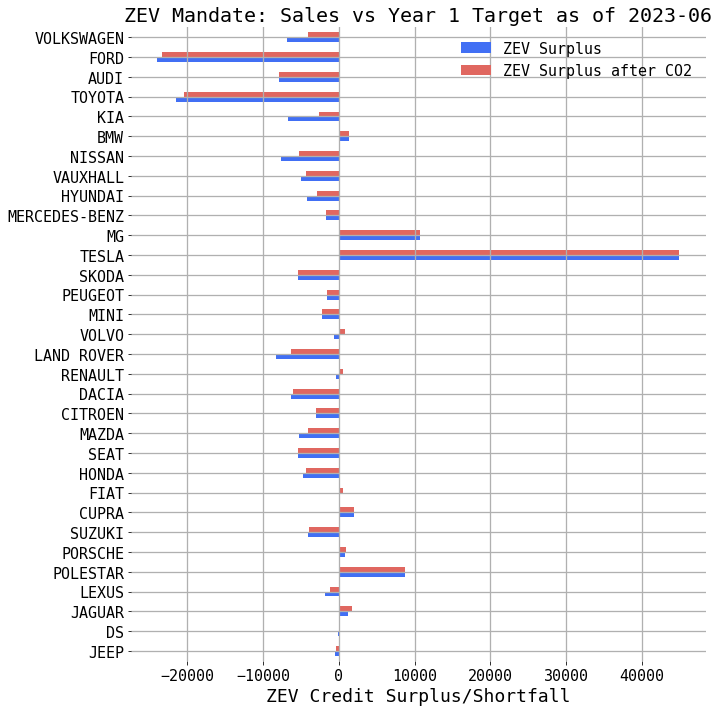

In [25]:
fig, ax = plt.subplots()

dfa.plot(x='make', y=[
    'ZEV Surplus', 
    'ZEV Surplus after CO2', 
    # 'ZEV Surplus after CO2 - Proposed'
], kind='barh', ax=ax, figsize=(10, 10))
ax.set_xlabel('ZEV Credit Surplus/Shortfall')
ax.set_ylabel('')

ax.set_title('ZEV Mandate: Sales vs Year 1 Target as of {}'.format(last_month))

plt.savefig('plots/top_20_last_12_months_{}.png'.format(this_month), transparent=False, bbox_inches='tight', dpi=300, facecolor='white')
plt.show()

In [26]:
# fig, ax = plt.subplots()

# dfa.plot(x='make', y=[
#     'ZEV Surplus', 
#     'ZEV Surplus after CO2', 
#     # 'ZEV Surplus after CO2 - Proposed'
# ], kind='barh', ax=ax, figsize=(10, 10))
# ax.set_xlabel('ZEV Credit Surplus/Shortfall')
# ax.set_ylabel('')

# ax.set_title('How close are manufacturers to reaching compliance')

# plt.savefig('plots/top_20_last_12_months.png', transparent=False, bbox_inches='tight', dpi=300)
# plt.show()

In [27]:
dfa['CO2 Performance'] = dfa.co2Activity / dfa.nonzevSales

In [28]:
dfa_sel = dfa[[
    'make',
    'totalSales',
    'nonzevSales',
    'zevSales',
    'co2Target',
    'CO2 Performance',
    'ZEVMallowances',
    'ZEV Surplus',
    'ZEV Surplus after CO2'
]].rename(columns={
    'make': 'Make',
    'totalSales': 'Total Sales',
    'co2Target': 'CO2 Target',
    'nonzevSales': 'Non-ZEV Sales',
    'zevSales': 'ZEV Sales',
    'ZEVMallowances': 'Allocated allowances',
    'ZEV Surplus': 'Allowance Surplus',
    'ZEV Surplus after CO2': 'Allowance Surplus (after CO2 transfers)'
})

# dfa_sel['Mean CO2'] = 
dfa_sel = round(dfa_sel, ndigits=2)

dfa_sel = dfa_sel.sort_values('Total Sales', ascending=False)

In [29]:
dfa_sel.to_csv('ZEV_compliance_tracker.csv')

In [30]:
# dfa_sel['Allowance Surplus (after)']

# Rolling Performance

In [23]:
%%bigquery df_act --project rugged-baton-283921
SELECT 
    VES.make,
    VES.monthOfFirstRegistration,
    COUNT(*) as totalSales,
    COUNTIF(VES.co2Emissions > 0) as nonzevSales,
    COUNTIF(VES.co2Emissions = 0) as zevSales,
    SUM(VES.co2Emissions) as co2Activity

FROM VES_dataset.VRN_UK VES
WHERE typeApproval = 'M1'
AND CAST(monthOfFirstRegistration AS DATE) > '2020-03-31'
AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
# AND make IN (
#     SELECT make
#     FROM VES_dataset.VRN_UK
#     WHERE typeApproval = 'M1'
#     AND monthOfFirstRegistration > '2020-03-31'
#     AND monthOfFirstRegistration < '2023-04-01'
#     GROUP BY make
#     ORDER BY COUNT(*) DESC
#     LIMIT 20
    
# )

# Volume limit
AND make IN (
    SELECT make
    FROM VES_dataset.VRN_UK
    WHERE typeApproval = 'M1'
    AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
    AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
    -- AND total > 2500
    GROUP BY make
    HAVING COUNT(*) > 2500
)



GROUP BY make, monthofFirstRegistration
ORDER BY totalSales ASC;

Downloading: 100%|██████████| 1237/1237 [00:00<00:00, 1907.52rows/s]


In [24]:
# If we want to filter out all but the top five/ten/twenty makes, we can use this
top_makes = df_act.groupby('make').sum().sort_values('totalSales', ascending=False).index.tolist()[:10]

In [25]:
# Make a copy to edit
df = df_act.copy()#.merge(car_targets, how='left', on='make')

In [26]:
df.head()

,make,monthOfFirstRegistration,totalSales,nonzevSales,zevSales,co2Activity
0,DS,2020-04-01 00:00:00+00:00,1,0,1,0.0
1,TESLA,2022-07-01 00:00:00+00:00,2,0,2,0.0
2,SUZUKI,2020-04-01 00:00:00+00:00,5,5,0,613.0
3,JEEP,2020-04-01 00:00:00+00:00,7,7,0,1574.0
4,TOYOTA,2020-04-01 00:00:00+00:00,8,8,0,831.0


In [27]:
# This turns our numbers into 12 month rolling totals/averages

dfs = []
makes = df.make.unique().tolist()

for make in makes:
    temp_df = df[df.make == make].set_index('monthOfFirstRegistration').sort_index().rolling(12).sum()
    temp_df = temp_df.reset_index().dropna()
    temp_df['make'] = make
    dfs.append(temp_df)
    
df = pd.concat(dfs)

In [28]:
# This gives us the targets for CO2 performance
df = df.reset_index().merge(car_targets, how='left', on='make')

In [29]:
df['co2Allowances'] = df.apply(lambda row: row.co2Target * row.nonzevSales, axis=1)
df['co2Compliance'] = df.apply(lambda row: row.co2Allowances - row.co2Activity, axis=1)

In [30]:
tdf = df[df.monthOfFirstRegistration == '2022-03-01']

tdf[tdf.co2Compliance < 0].co2Compliance.sum()

-49656.119107899605

In [31]:
(co2_trading_supply + co2_trading_demand) / co2_trading_supply

NameError: name 'co2_trading_supply' is not defined

In [32]:
dfs = []

months = list(df.monthOfFirstRegistration.unique())

for month in months:
    tdf = df[df.monthOfFirstRegistration == month]
    co2_trading_demand = tdf[tdf.co2Compliance < 0].co2Compliance.sum()
    co2_trading_supply = tdf[tdf.co2Compliance > 0].co2Compliance.sum()

    co2_trading_diff = co2_trading_supply + co2_trading_demand
    co2_trading_diff_perc = co2_trading_diff / co2_trading_supply
    
    tdf['co2ComplianceAdj'] = tdf.apply(lambda row: co2ComplianceAdjFunc(row=row, total_trading_diff_perc = co2_trading_diff_perc), axis=1)
    
    dfs.append(tdf)

<ipython-input-32-71e4c13204e9>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['co2ComplianceAdj'] = tdf.apply(lambda row: co2ComplianceAdjFunc(row=row, total_trading_diff_perc = co2_trading_diff_perc), axis=1)
<ipython-input-32-71e4c13204e9>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['co2ComplianceAdj'] = tdf.apply(lambda row: co2ComplianceAdjFunc(row=row, total_trading_diff_perc = co2_trading_diff_perc), axis=1)
<ipython-input-32-71e4c13204e9>:13: SettingWithCopyWarning: 
A value is tryi

In [33]:
df = pd.concat(dfs)

In [34]:
df['co2_to_mandate_allowances'] = df.apply(lambda row: co2_to_zev(row, mandate=.22), axis=1)

In [35]:
mandate = .22
df['ZEVMallowances'] = df.apply(lambda row: (1-mandate) * row.totalSales, axis=1)
df['ZEV Surplus'] = df.apply(lambda row: row.ZEVMallowances - row.nonzevSales, axis=1)
df['ZEV Surplus after CO2'] = df.apply(lambda row: row['ZEV Surplus'] + row.co2_to_mandate_allowances, axis=1)
# df['ZEV Surplus after CO2 - Proposed'] = df.apply(lambda row: row['ZEV Surplus'] + row.proposed_co2_to_mandate_allowances, axis=1)

In [36]:
# Calculate effective target

dfs = []

months = list(df.monthOfFirstRegistration.unique())

for month in months:
    tdf = df[df.monthOfFirstRegistration == month]
    
    tdf['implied_target'] = 1 - ((tdf.groupby(['monthOfFirstRegistration']).sum()['ZEVMallowances'] + (tdf.groupby(['monthOfFirstRegistration']).sum()['co2_to_mandate_allowances'])) / tdf.groupby(['monthOfFirstRegistration']).sum()['totalSales'])
    dfs.append(tdf)

<ipython-input-36-d2797a4f042e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['implied_target'] = 1 - ((tdf.groupby(['monthOfFirstRegistration']).sum()['ZEVMallowances'] + (tdf.groupby(['monthOfFirstRegistration']).sum()['co2_to_mandate_allowances'])) / tdf.groupby(['monthOfFirstRegistration']).sum()['totalSales'])


<AxesSubplot:xlabel='monthOfFirstRegistration'>

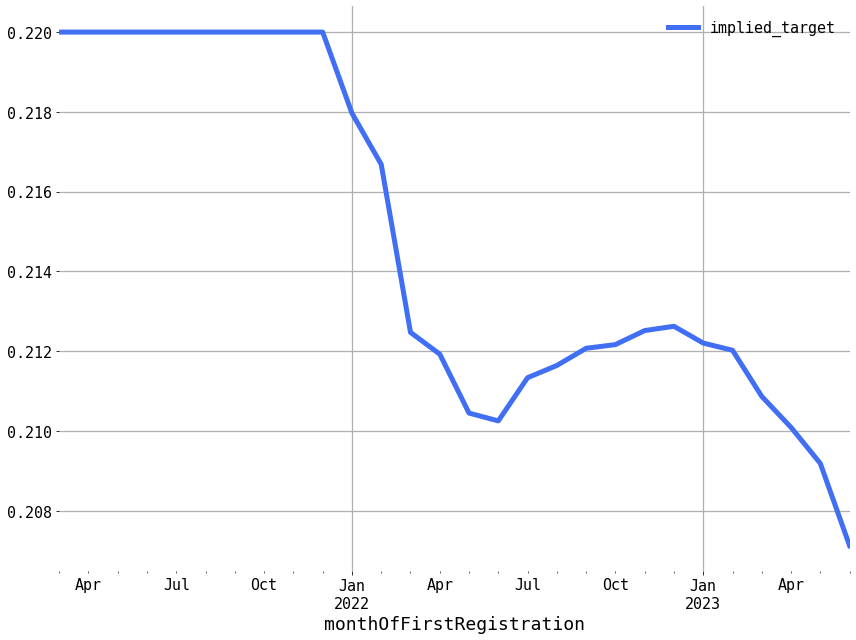

In [37]:
# Implied targets

# We consider the additional Co2 -> zev credits and figure out what implied % target results from this flexibility
imtg = 1 - ((df.groupby(['monthOfFirstRegistration']).sum()['ZEVMallowances'] + (df.groupby(['monthOfFirstRegistration']).sum()['co2_to_mandate_allowances'])) / df.groupby(['monthOfFirstRegistration']).sum()['totalSales'])
imtg = imtg.to_frame(name='implied_target')
imtg.plot()

<AxesSubplot:xlabel='monthOfFirstRegistration'>

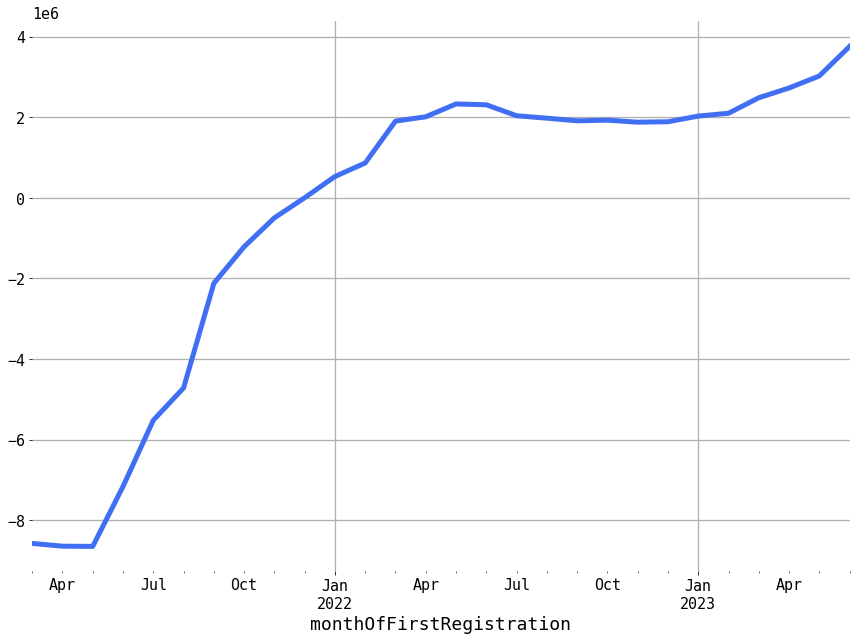

In [38]:
df.groupby(['monthOfFirstRegistration']).sum().co2Compliance.plot()

In [39]:
# Are there any manufacturers failing to make Co2 compliance but with surplus ZEV credits, who would need to transfer ZEV credits into the regime 
# We assume that manufacturers would rather transfer from CO2 than purchase CO2 allowances. 
# df[(df['ZEV Surplus'] > 0) & (df.co2Compliance < 0)]

In [40]:
df[df.monthOfFirstRegistration == '2023-04-01']

,index,monthOfFirstRegistration,totalSales,nonzevSales,zevSales,co2Activity,make,co2Target,co2Allowances,co2Compliance,co2ComplianceAdj,co2_to_mandate_allowances,ZEVMallowances,ZEV Surplus,ZEV Surplus after CO2
25,36,2023-04-01 00:00:00+00:00,3711.0,3038.0,673.0,337537.0,DS,123.501599,3.751979e+05,3.766086e+04,20549.193142,123.049061,2894.58,-143.42,-20.370939
53,36,2023-04-01 00:00:00+00:00,52507.0,0.0,52507.0,0.0,TESLA,NaN,NaN,NaN,NaN,0.000000,40955.46,40955.46,40955.460000
81,36,2023-04-01 00:00:00+00:00,17607.0,17607.0,0.0,2071571.0,SUZUKI,117.626027,2.071041e+06,-5.295514e+02,-529.551413,0.000000,13733.46,-3873.54,-3873.540000
109,36,2023-04-01 00:00:00+00:00,2694.0,2694.0,0.0,275208.0,JEEP,163.144251,4.395106e+05,1.643026e+05,89649.737149,148.170000,2101.32,-592.68,-444.510000
137,36,2023-04-01 00:00:00+00:00,99132.0,98474.0,658.0,10675697.0,TOYOTA,110.473882,1.087881e+07,2.031080e+05,110823.448327,663.613463,77322.96,-21151.04,-20487.426537
162,33,2023-04-01 00:00:00+00:00,10047.0,2.0,10045.0,26.0,POLESTAR,192.000000,3.840000e+02,3.580000e+02,195.338378,1.169691,7836.66,7834.66,7835.829691
190,36,2023-04-01 00:00:00+00:00,21606.0,21291.0,315.0,2595965.0,HONDA,124.830257,2.657761e+06,6.179600e+04,33718.243114,201.905647,16852.68,-4438.32,-4236.414353
218,36,2023-04-01 00:00:00+00:00,24668.0,23960.0,708.0,3078377.0,MAZDA,138.969935,3.329720e+06,2.513427e+05,137142.083709,821.210082,19241.04,-4718.96,-3897.749918
246,36,2023-04-01 00:00:00+00:00,28472.0,28472.0,0.0,3768426.0,DACIA,134.542766,3.830702e+06,6.227562e+04,33979.942776,203.472711,22208.16,-6263.84,-6060.367289
274,36,2023-04-01 00:00:00+00:00,14932.0,10841.0,4091.0,2340188.0,PORSCHE,219.397277,2.378486e+06,3.829788e+04,20896.776153,125.130396,11646.96,805.96,931.090396


NameError: name 'last_month' is not defined

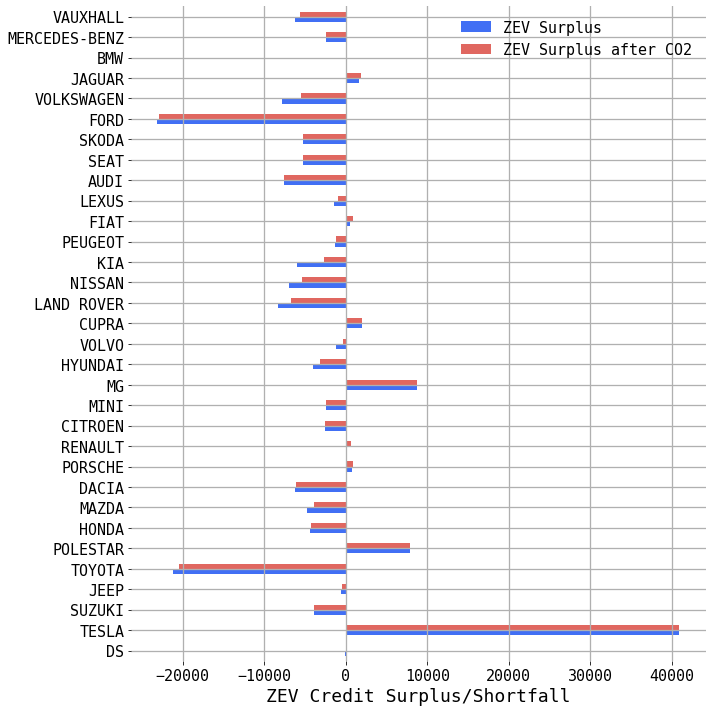

In [41]:
fig, ax = plt.subplots()

df[df.monthOfFirstRegistration == '2023-04-01'].plot(x='make', y=[
    'ZEV Surplus', 
    'ZEV Surplus after CO2', 
    # 'ZEV Surplus after CO2 - Proposed'
], kind='barh', ax=ax, figsize=(10, 10))
ax.set_xlabel('ZEV Credit Surplus/Shortfall')
ax.set_ylabel('')

ax.set_title('ZEV Mandate: Sales vs Year 1 Target as of {}'.format(last_month))

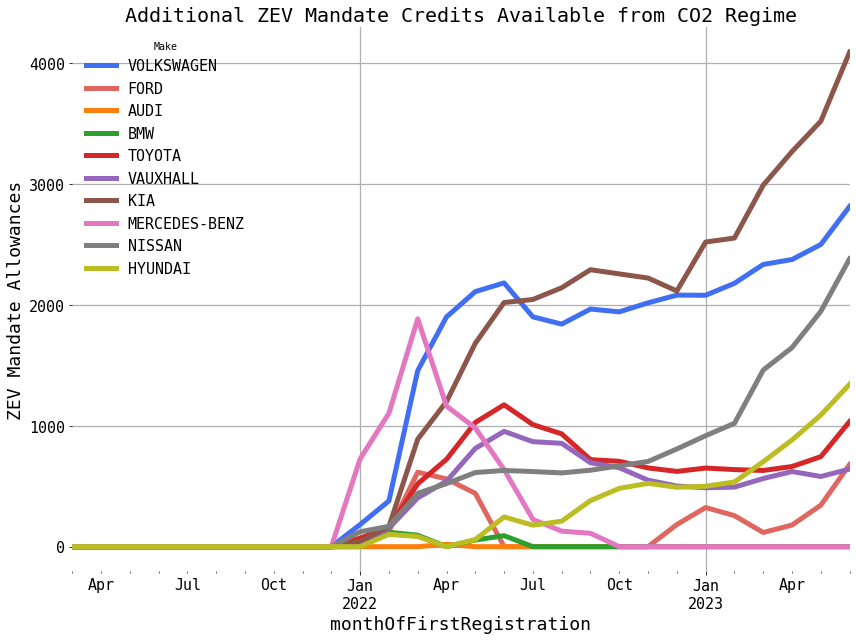

In [42]:
fig, ax = plt.subplots()

df.pivot(index='monthOfFirstRegistration', columns='make', values='co2_to_mandate_allowances')[top_makes].plot(ax=ax)
ax.set_ylabel('ZEV Mandate Allowances')
ax.legend(title='Make', loc='upper left')
ax.set_title('Additional ZEV Mandate Credits Available from CO2 Regime')

plt.show()

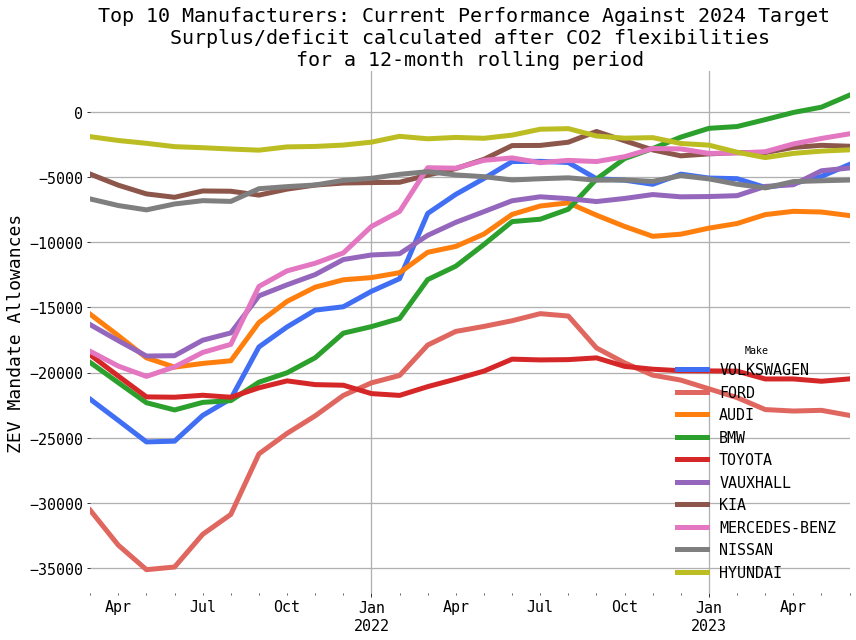

In [43]:
fig, ax = plt.subplots()

df.pivot(index='monthOfFirstRegistration', columns='make', values='ZEV Surplus after CO2')[top_makes].plot(ax=ax)
ax.set_ylabel('ZEV Mandate Allowances')
ax.set_xlabel('')
ax.set_title('Top 10 Manufacturers: Current Performance Against 2024 Target \n Surplus/deficit calculated after CO2 flexibilities \nfor a 12-month rolling period')
ax.legend(title='Make', loc='lower right')

plt.savefig('plots/top_10_manufacturers_zevm.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

In [44]:
df.columns = [x.replace(' ', '') for x in df.columns]

In [45]:
df = df.drop(columns='index')

In [46]:
# df['monthOfFirstRegistration'] = df.monthOfFirstRegistration.apply(lambda x: x.strftime('%Y-%m-%d'))

In [47]:
df.monthOfFirstRegistration.unique()

<DatetimeArray>
['2021-03-01 00:00:00+00:00', '2021-04-01 00:00:00+00:00',
 '2021-05-01 00:00:00+00:00', '2021-06-01 00:00:00+00:00',
 '2021-07-01 00:00:00+00:00', '2021-08-01 00:00:00+00:00',
 '2021-09-01 00:00:00+00:00', '2021-10-01 00:00:00+00:00',
 '2021-11-01 00:00:00+00:00', '2021-12-01 00:00:00+00:00',
 '2022-01-01 00:00:00+00:00', '2022-02-01 00:00:00+00:00',
 '2022-03-01 00:00:00+00:00', '2022-04-01 00:00:00+00:00',
 '2022-05-01 00:00:00+00:00', '2022-06-01 00:00:00+00:00',
 '2022-07-01 00:00:00+00:00', '2022-08-01 00:00:00+00:00',
 '2022-09-01 00:00:00+00:00', '2022-10-01 00:00:00+00:00',
 '2022-11-01 00:00:00+00:00', '2022-12-01 00:00:00+00:00',
 '2023-01-01 00:00:00+00:00', '2023-02-01 00:00:00+00:00',
 '2023-03-01 00:00:00+00:00', '2023-04-01 00:00:00+00:00',
 '2023-05-01 00:00:00+00:00', '2023-06-01 00:00:00+00:00']
Length: 28, dtype: datetime64[ns, UTC]

In [48]:

client = bigquery.Client()
table_id = 'zevMandate.carRollingPerformance'

job_config = bigquery.LoadJobConfig(
    schema=[
        bigquery.SchemaField('monthOfFirstRegistration', 'DATE'),
        bigquery.SchemaField('make', 'STRING'),
        bigquery.SchemaField('totalSales', 'INTEGER'),
        bigquery.SchemaField('nonzevSales', 'INTEGER'),
        bigquery.SchemaField('zevSales', 'INTEGER'),
        bigquery.SchemaField('co2Activity', 'FLOAT'),
        bigquery.SchemaField('co2Target', 'FLOAT'),
        bigquery.SchemaField('co2Allowances', 'FLOAT'),
        bigquery.SchemaField('co2Compliance', 'FLOAT'),
        bigquery.SchemaField('co2ComplianceAdj', 'FLOAT'),
        bigquery.SchemaField('ZEVMallowances', 'FLOAT'),
        bigquery.SchemaField('ZEVSurplus', 'FLOAT'),
        bigquery.SchemaField('co2_to_mandate_allowances', 'FLOAT'),
        bigquery.SchemaField('ZEVSurplusafterCO2', 'FLOAT')
        
    ]
)

job_config.write_disposition = 'WRITE_TRUNCATE'

job = client.load_table_from_dataframe(df, table_id, job_config=job_config)

job.result()

In [95]:
df

,monthOfFirstRegistration,totalSales,nonzevSales,zevSales,co2Activity,make,co2Target,co2Allowances,co2Compliance,co2ComplianceAdj,co2_to_mandate_allowances,ZEVMallowances,ZEVSurplus,ZEVSurplusafterCO2
0,2021-03-01 00:00:00+00:00,2075.0,1573.0,502.0,206131.0,DS,123.501599,1.942680e+05,-11862.984005,-11862.984005,0.000000,1618.50,45.50,45.500000
28,2021-03-01 00:00:00+00:00,25135.0,0.0,25135.0,0.0,TESLA,NaN,NaN,NaN,NaN,0.000000,19605.30,19605.30,19605.300000
56,2021-03-01 00:00:00+00:00,16681.0,16681.0,0.0,2050988.0,SUZUKI,117.626027,1.962120e+06,-88868.251952,-88868.251952,0.000000,13011.18,-3669.82,-3669.820000
84,2021-03-01 00:00:00+00:00,4240.0,4240.0,0.0,745308.0,JEEP,163.144251,6.917316e+05,-53576.374197,-53576.374197,0.000000,3307.20,-932.80,-932.800000
137,2021-03-01 00:00:00+00:00,19464.0,19212.0,252.0,2751678.0,MAZDA,138.969935,2.669890e+06,-81787.600837,-81787.600837,0.000000,15181.92,-4030.08,-4030.080000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,2023-06-01 00:00:00+00:00,148318.0,122517.0,25801.0,16398432.0,VOLKSWAGEN,139.812376,1.712939e+07,730960.842860,470336.891384,2816.388571,115688.04,-6828.96,-4012.571429
800,2023-06-01 00:00:00+00:00,10504.0,6917.0,3587.0,1099619.0,JAGUAR,174.377538,1.206169e+06,106550.428942,68559.893479,410.538284,8193.12,1276.12,1686.658284
828,2023-06-01 00:00:00+00:00,94030.0,72036.0,21994.0,9691483.0,BMW,130.096266,9.371615e+06,-319868.401004,-319868.401004,0.000000,73343.40,1307.40,1307.400000
856,2023-06-01 00:00:00+00:00,71307.0,57283.0,14024.0,8283515.0,MERCEDES-BENZ,137.096894,7.853321e+06,-430193.649107,-430193.649107,0.000000,55619.46,-1663.54,-1663.540000


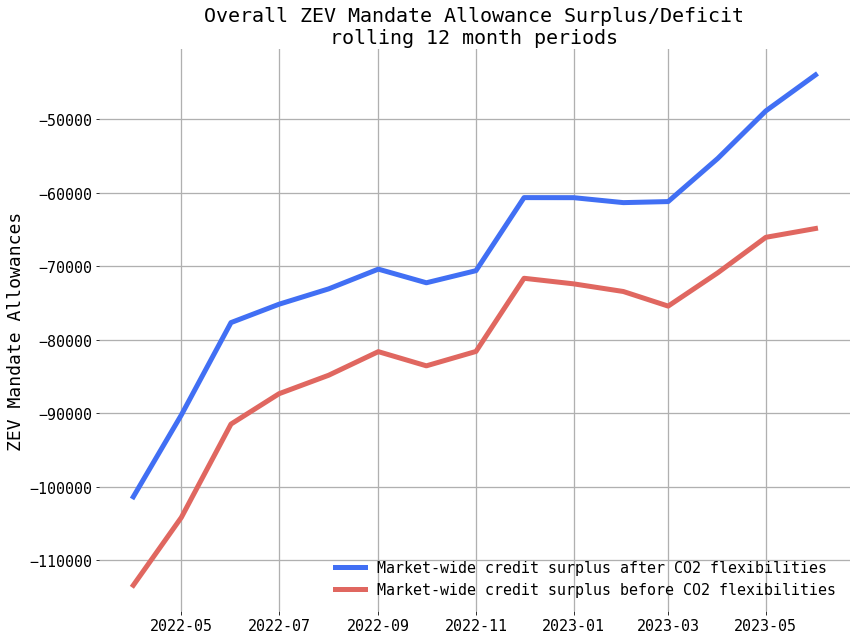

In [96]:
fig, ax = plt.subplots()

# ax.plot(df.groupby('monthOfFirstRegistration').sum()['ZEV Surplus'], label='Market-wide credit surplus')
plt_df = df.groupby('monthOfFirstRegistration').sum()[['ZEVSurplusafterCO2', 'ZEVSurplus']]

ax.plot(plt_df[plt_df.index > '2022-03-01']['ZEVSurplusafterCO2'], label='Market-wide credit surplus after CO2 flexibilities')
ax.plot(plt_df[plt_df.index > '2022-03-01']['ZEVSurplus'], label='Market-wide credit surplus before CO2 flexibilities')
# ax.plot(df.groupby('monthOfFirstRegistration').sum()['ZEV Surplus after CO2 - Proposed'], label='Proposed Market-wide credit surplus after CO2 flexibilities')
ax.set_ylabel('ZEV Mandate Allowances')

# ax.legend(loc='lower right')
ax.set_title('Overall ZEV Mandate Allowance Surplus/Deficit\nrolling 12 month periods')
ax.legend(loc='lower right')

plt.savefig('plots/aggregate_demand_credits_{}.png'.format(this_month), transparent=False, bbox_inches='tight', dpi=300)
plt.show()

In [97]:
df.groupby('monthOfFirstRegistration').sum()[['ZEVSurplusafterCO2', 'ZEVSurplus']]

,ZEVSurplusafterCO2,ZEVSurplus
monthOfFirstRegistration,,
2021-03-01 00:00:00+00:00,-209206.660000,-209206.66
2021-04-01 00:00:00+00:00,-232534.720000,-232534.72
2021-05-01 00:00:00+00:00,-250345.300000,-250345.30
2021-06-01 00:00:00+00:00,-246194.440000,-246194.44
2021-07-01 00:00:00+00:00,-232870.280000,-232870.28
2021-08-01 00:00:00+00:00,-227032.320000,-227032.32
2021-09-01 00:00:00+00:00,-192003.000000,-192003.00
2021-10-01 00:00:00+00:00,-179143.600000,-179143.60
2021-11-01 00:00:00+00:00,-168199.000000,-168199.00


### Car Targets CO2

In [116]:
df['meanCo2'] = df.apply(lambda row: row.co2Activity / row.nonzevSales if row.nonzevSales >0 else np.nan , axis=1)

In [117]:
car_targets[car_targets.make.isin(top_makes)]

,make,co2Target
0,VOLKSWAGEN,139.812867
2,HYUNDAI,127.235970
3,VAUXHALL,127.636984
21,BMW,130.089336
22,FORD,127.003032
23,NISSAN,142.631400
25,AUDI,142.005839
34,MERCEDES-BENZ,137.094325
61,KIA,135.696620
62,TOYOTA,110.472814


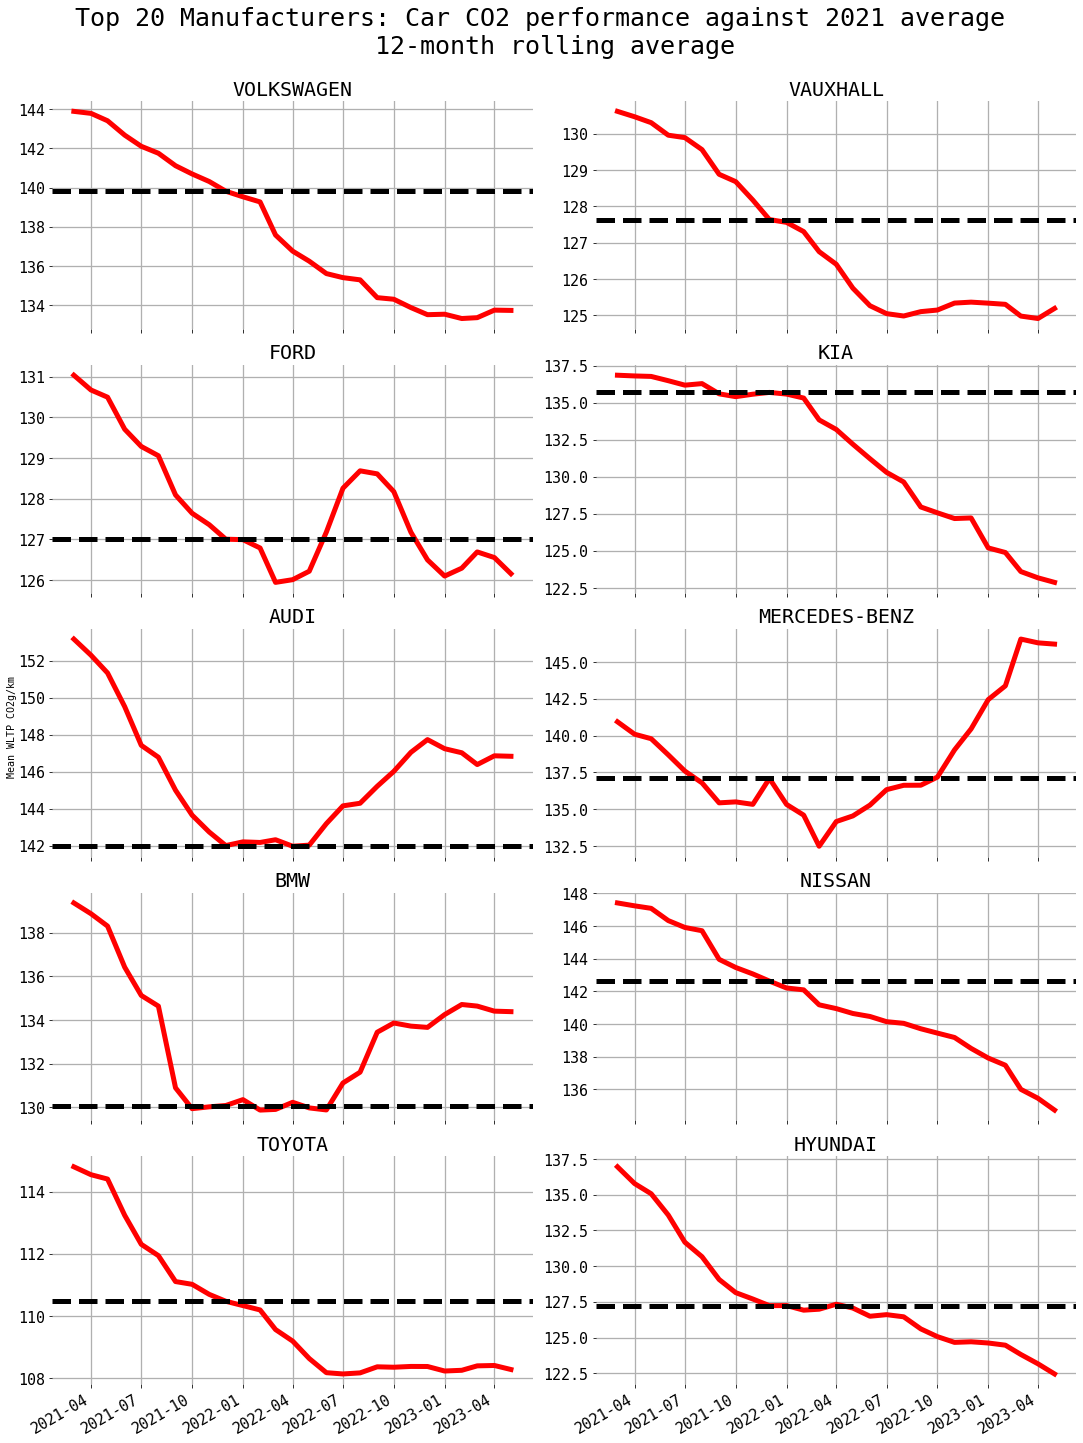

In [118]:
fig, ax = plt.subplots(5, 2, figsize=(15, 20))

# # df.pivot(index='monthOfFirstRegistration', columns='make', values='meanCo2')[top_makes].plot(ax=ax)
# # ax.axhline(car_targets[car_targets.make.isin(top_makes)])
# # ax.set_xlabel('')
# # ax.legend(title='Make', loc='lower right')

plt_df = df.pivot(index='monthOfFirstRegistration', columns='make', values='meanCo2')[top_makes]



for e, make in enumerate(top_makes[:5]):
    ax[e, 0].plot(plt_df[make], c='red')
    ax[e, 0].axhline(car_targets[car_targets.make == make].co2Target.values, c='black', linestyle='--')
    ax[e, 0].set_title(make)
    ax[e, 0].figure.autofmt_xdate()
    # ax[e, 0].set_ylabel('Mean WLPT CO2g/km')
    
for e, make in enumerate(top_makes[5:]):
    ax[e, 1].plot(plt_df[make], c='red')
    ax[e, 1].axhline(car_targets[car_targets.make == make].co2Target.values, c='black', label='2021 Baseline Target', linestyle='--')
    ax[e, 1].set_title(make)
    ax[e, 1].figure.autofmt_xdate()
    # ax[e, 1].set_ylabel('Mean WLPT CO2g/km')
    

fig.text(0.0, 0.5, 'Mean WLTP CO2g/km', va='center', rotation='vertical', fontsize=10)
fig.suptitle('Top 20 Manufacturers: Car CO2 performance against 2021 average \n 12-month rolling average', y=1, fontsize=25)
fig.tight_layout()
# plt.show()

plt.savefig('plots/co2.png', transparent=False, bbox_inches='tight', dpi=300)

# ax[0, 0]

In [119]:
#A function to calculate CO2 flexibilities
def co2_to_zev(row, mandate):
    new_zev_credits = 0
    limit = mandate*.25
    limit = limit * row.totalSales
    
    if row.co2ComplianceAdj > 0:
        new_zev_credits = row.co2ComplianceAdj / 167
    
    if new_zev_credits > limit:
        new_zev_credits = limit
        
    return new_zev_credits

In [120]:
targets = bq.from_bq_to_dataframe(
    query="""
    SELECT make, AVG(co2Emissions) as co2Target
    FROM VES_dataset.VRN_UK
    WHERE typeApproval = 'M1'
    AND monthOfFirstRegistration > '2020-12-31'
    AND monthOfFirstRegistration < '2022-01-01'
    AND co2Emissions > 0
    AND make IN (
        SELECT make
        FROM VES_dataset.VRN_UK
        WHERE typeApproval = 'M1'
        AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
        AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
        -- AND total >= 2500
        GROUP BY make
        HAVING COUNT(*) >= 2500
    )
    
    GROUP BY make
    """)

In [121]:
activity = bq.from_bq_to_dataframe(
    query = """
    SELECT 
        VES.make,
        VES.monthOfFirstRegistration,
        COUNT(*) as totalSales,
        COUNTIF(VES.co2Emissions > 0) as nonzevSales,
        COUNTIF(VES.co2Emissions = 0) as zevSales,
        SUM(VES.co2Emissions) as co2Activity

    FROM VES_dataset.VRN_UK VES
    WHERE typeApproval = 'M1'
    AND CAST(monthOfFirstRegistration AS DATE) > '2020-03-31'
    AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
    
    # Volume limit
    AND make IN (
        SELECT make
        FROM VES_dataset.VRN_UK
        WHERE typeApproval = 'M1'
        AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
        AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
        -- AND total > 2500
        GROUP BY make
        HAVING COUNT(*) > 2500
    )



    GROUP BY make, monthofFirstRegistration
    ORDER BY totalSales ASC;

    """

)

In [122]:
dfs = []
makes = activity.make.unique().tolist()

for make in makes:

    temp_df = activity[(activity.make == make)].set_index('monthOfFirstRegistration').sort_index().rolling(12).sum()
    temp_df = temp_df.reset_index().dropna()
    temp_df['make'] = make
    dfs.append(temp_df)
    
activity = pd.concat(dfs)

In [128]:
ukevs

,monthOfFirstRegistration,make,totalSales,nonzevSales,zevSales,co2Activity,co2Target,co2Allowances,co2Compliance
0,2021-03-01 00:00:00+00:00,AUDI,99805.0,93364.0,6441.0,14299613.0,142.005839,1.325823e+07,-1.041380e+06
1,2021-03-01 00:00:00+00:00,BMW,106105.0,101983.0,4122.0,14213222.0,130.089336,1.326690e+07,-9.463213e+05
2,2021-03-01 00:00:00+00:00,CITROEN,26971.0,26734.0,237.0,3520716.0,126.129638,3.371950e+06,-1.487663e+05
3,2021-03-01 00:00:00+00:00,DACIA,16514.0,16514.0,0.0,2326434.0,134.542766,2.221839e+06,-1.045948e+05
4,2021-03-01 00:00:00+00:00,DS,2075.0,1573.0,502.0,206131.0,123.471191,1.942202e+05,-1.191082e+04
...,...,...,...,...,...,...,...,...,...
848,2023-05-01 00:00:00+00:00,TESLA,55827.0,0.0,55827.0,0.0,NaN,NaN,NaN
849,2023-05-01 00:00:00+00:00,TOYOTA,100255.0,99604.0,651.0,10785042.0,110.472814,1.100353e+07,2.184922e+05
850,2023-05-01 00:00:00+00:00,VAUXHALL,82714.0,69603.0,13110.0,8713838.0,127.636984,8.883917e+06,1.700790e+05
851,2023-05-01 00:00:00+00:00,VOLKSWAGEN,144926.0,120472.0,24454.0,16111177.0,139.812867,1.684354e+07,7.323587e+05


In [ ]:
# # Adjust CO2 -> ZEV transfers to take into account demand from non-compliant manufacturers. 

# co2_trading_demand = dfa[dfa.co2Compliance < 0].co2Compliance.sum()
# co2_trading_supply = dfa[dfa.co2Compliance > 0].co2Compliance.sum()

# co2_trading_diff = co2_trading_supply + co2_trading_demand
# co2_trading_diff_perc = co2_trading_diff / co2_trading_supply

# dfa['co2ComplianceAdj'] = dfa.apply(lambda row: co2ComplianceAdjFunc(row=row, total_trading_diff_perc = co2_trading_diff_perc), axis=1)

In [ ]:
# To calculate the CO2 flex that comes from rUK, we need to use the function above. We'll take a look at the whole of the UK's additional CO2 -> ZEV credits

ukevs = activity.groupby(['monthOfFirstRegistration', 'make']).sum().reset_index()

In [ ]:
dfs_list = []

for y in ukevs.monthOfFirstRegistration.unique():
    tdf = ukevs[ukevs.monthOfFirstRegistration == y]
    
    co2_trading_demand = tdf[tdf.co2Compliance < 0].co2Compliance.sum()
    co2_trading_supply = tdf[tdf.co2Compliance > 0].co2Compliance.sum()

    co2_trading_diff = co2_trading_supply + co2_trading_demand
    co2_trading_diff_perc = co2_trading_diff / co2_trading_supply

    tdf['co2ComplianceAdj'] = tdf.apply(lambda row: co2ComplianceAdjFunc(row=row, total_trading_diff_perc = co2_trading_diff_perc), axis=1)
    
    dfs_list.append(tdf)
    
ukevs = pd.concat(dfs_list)

In [134]:


# First, we bring in the targets
ukevs = ukevs.merge(targets, how='left', on='make')

# then we calculate CO2 allowances
ukevs['co2Allowances'] = ukevs.apply(lambda row: row.co2Target * row.nonzevSales, axis=1)
ukevs['co2Compliance'] = ukevs.apply(lambda row: row.co2Allowances - row.co2Activity, axis=1)

# How many available for transfer
ukevs['co2_to_mandate_allowances'] = ukevs.apply(lambda row: co2_to_zev(row, mandate=.22), axis=1)

# Then, the mandate
mandate = .22
ukevs['ZEVMallowances'] = ukevs.apply(lambda row: (1-mandate) * row.totalSales, axis=1)
ukevs['ZEV Surplus'] = ukevs.apply(lambda row: row.ZEVMallowances - row.nonzevSales, axis=1)
ukevs['ZEV Surplus after CO2'] = ukevs.apply(lambda row: row['ZEV Surplus'] + row.co2_to_mandate_allowances, axis=1)

ukevs['mean_co2'] = ukevs.co2Activity / ukevs.nonzevSales


In [135]:
len(ukevs.make.unique())

32

### Visualising rolling CO2 performance

In [139]:
ukevs.groupby(['monthOfFirstRegistration']).sum()['ZEV Surplus after CO2']

monthOfFirstRegistration
2021-03-01 00:00:00+00:00   -209181.900000
2021-04-01 00:00:00+00:00   -232506.320000
2021-05-01 00:00:00+00:00   -250314.920000
2021-06-01 00:00:00+00:00   -246168.040000
2021-07-01 00:00:00+00:00   -232845.740000
2021-08-01 00:00:00+00:00   -227010.420000
2021-09-01 00:00:00+00:00   -191986.620000
2021-10-01 00:00:00+00:00   -179128.000000
2021-11-01 00:00:00+00:00   -168182.740000
2021-12-01 00:00:00+00:00   -157398.300000
2022-01-01 00:00:00+00:00   -150997.871239
2022-02-01 00:00:00+00:00   -143627.631863
2022-03-01 00:00:00+00:00   -110802.767331
2022-04-01 00:00:00+00:00   -101350.967039
2022-05-01 00:00:00+00:00    -90216.999519
2022-06-01 00:00:00+00:00    -77656.486764
2022-07-01 00:00:00+00:00    -75160.870837
2022-08-01 00:00:00+00:00    -73069.310413
2022-09-01 00:00:00+00:00    -70387.008520
2022-10-01 00:00:00+00:00    -72243.886827
2022-11-01 00:00:00+00:00    -70598.585129
2022-12-01 00:00:00+00:00    -60661.651851
2023-01-01 00:00:00+00:00    

Error with 5: list index out of range


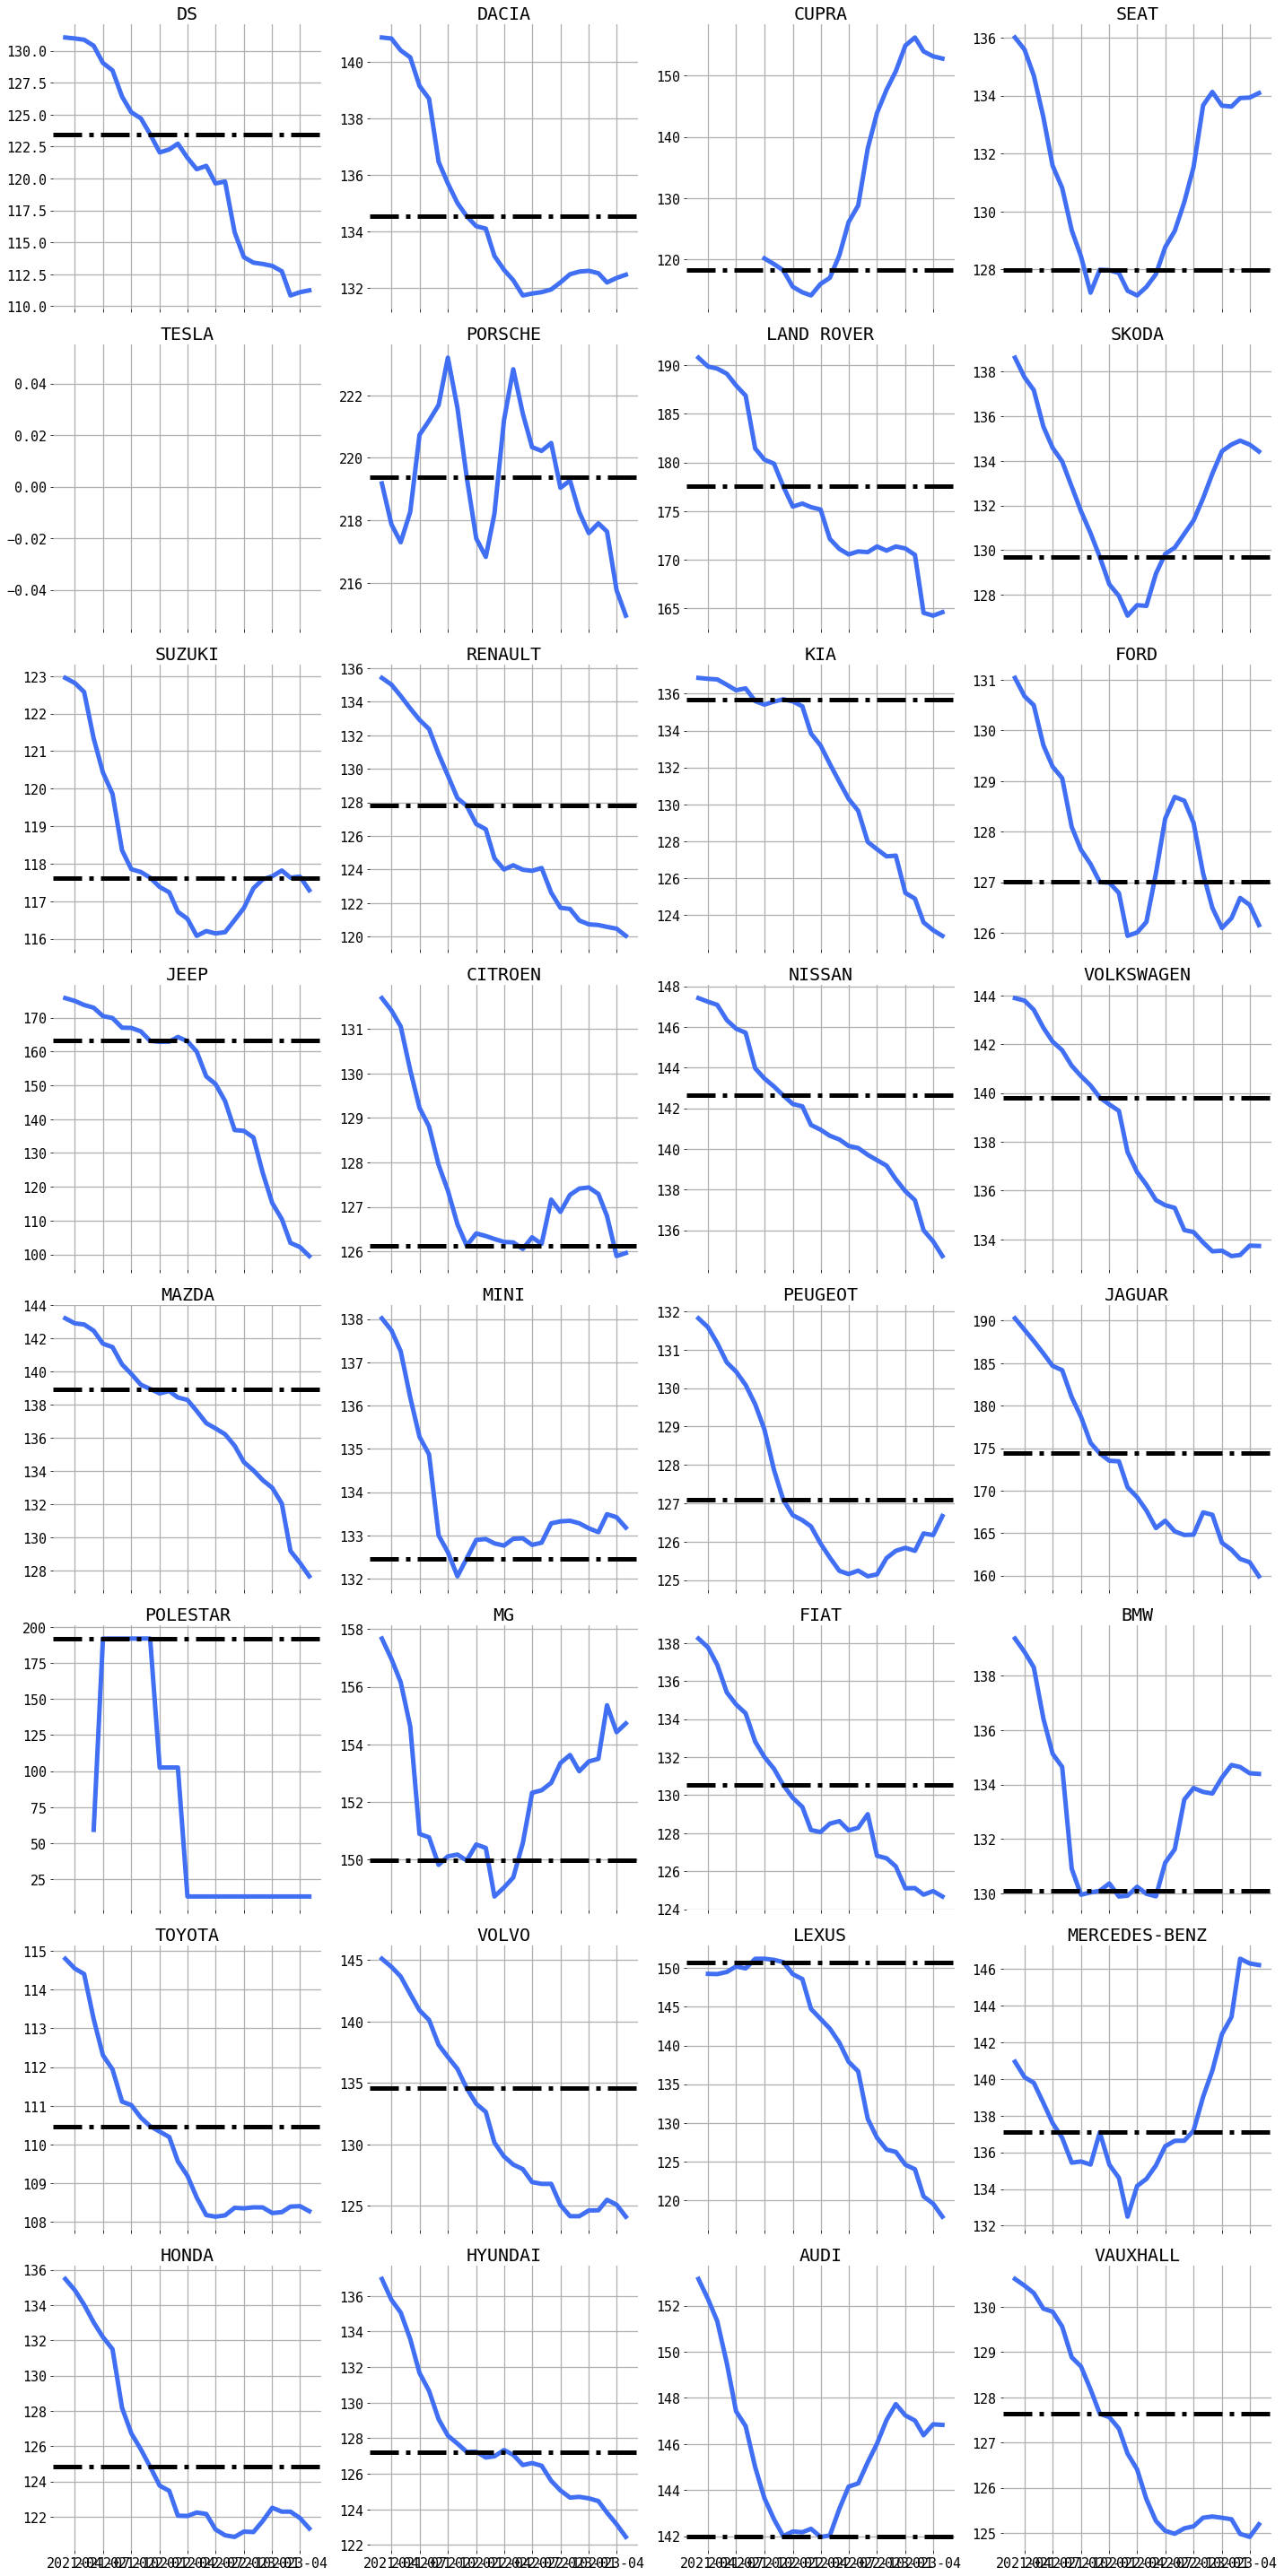

In [136]:
nrows = 8
ncols = 4

list_list_makes = []


fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(20, 40), sharex=True)

# myLocator = mticker.MultipleLocator(4)

rows = list(range(0, nrows))
columns = list(range(0, ncols))

counter = 0
for row in rows:
    for column in columns:
        try:
            # print(counter)
            make = makes[row::nrows][column]
            ax[row, column].plot(ukevs[ukevs.make == make].set_index('monthOfFirstRegistration').mean_co2, label='{} CO2 Wales Performance'.format(make))
            # ax[row, column].plot(ukevs[ukevs.make == make].set_index('monthOfFirstRegistration').mean_co2, label='{} CO2 rUK Performance'.format(make))
            ax[row, column].set_title(make)
            
            ax[row, column].axhline((targets[targets.make == make].co2Target.tolist()[0]), linestyle='dashdot', color='black', label='{} CO2 Target'.format(make))
            # ax[row, column].legend()
            # ax[row, column].xaxis.set_major_locator(myLocator)
        
        except Exception as e:
            print("Error with {m}: {e}".format(m=counter, e=e))
        
        counter += 1
    counter += 1    
    
# fig.legend()
fig.tight_layout()

# plt.savefig('plots/wales_uk_co2.png', transparent=True, bbox_inches='tight', dpi=300)

## Carbon rating of new cars & vans

In [ ]:
%%bigquery c2r --project rugged-baton-283921
SELECT monthOfFirstRegistration, fuelType, AVG(co2Emissions) as meanCo2
FROM VES_dataset.VRN_UK
WHERE typeApproval = 'M1'

AND fuelType IN ('PETROL', 'DIESEL', 'HYBRID ELECTRIC')
AND monthOfFirstRegistration > '2020-04-01'
AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
GROUP BY monthOfFirstRegistration, FuelType

In [ ]:
# c2r['fuelType'] = c2r.fuelType.apply(ft_cleaner)

In [ ]:
c2r['monthOfFirstRegistration'] = pd.to_datetime(c2r.monthOfFirstRegistration)
c2r = c2r.pivot(index='monthOfFirstRegistration', columns='fuelType', values='meanCo2')
c2r.columns = [x.title() for x in c2r.columns]

In [ ]:
fig, ax = plt.subplots()

c2r.plot(ax=ax)

ax.set_title('Monthly Mean CO2 Rating of New Cars by Fuel Type to {}'.format(last_month))
ax.set_ylabel('WLTP gCO2/km Rating')
ax.set_xlabel('Month of Registration')

plt.savefig('plots/mean_co2_fueltype_{}.png'.format(this_month), transparent=False, bbox_inches='tight', dpi=300, facecolor='white')

In [ ]:
%%bigquery wei --project rugged-baton-283921
SELECT monthOfFirstRegistration, fuelType, AVG(revenueWeight) as meanCo2
FROM VES_dataset.VRN_UK
WHERE typeApproval = 'M1'

AND fuelType IN ('PETROL', 'DIESEL', 'HYBRID ELECTRIC', 'ELECTRICITY')
AND monthOfFirstRegistration > '2020-04-01'
AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
GROUP BY monthOfFirstRegistration, FuelType

In [ ]:
wei['monthOfFirstRegistration'] = pd.to_datetime(wei.monthOfFirstRegistration)
wei = wei.pivot(index='monthOfFirstRegistration', columns='fuelType', values='meanCo2')
wei.columns = [x.title() for x in wei.columns]

In [ ]:
fig, ax = plt.subplots(2, figsize=(10, 10))

c2r.plot(ax=ax[0])
wei.plot(ax=ax[1])

ax[0].set_title('Monthly Mean CO2 Rating of New Cars by Fuel Type to {}'.format(last_month))
ax[0].set_ylabel('WLTP gCO2/km Rating')
ax[0].set_xlabel('Month of Registration')

ax[1].set_title('Monthly Mean Revenue Weight of New Cars by Fuel Type to {}'.format(last_month))
ax[1].set_ylabel('Revenue Weight (kg)')
ax[1].set_xlabel('Month of Registration')

plt.savefig('plots/mean_co2_fueltype_{}.png'.format(this_month), transparent=False, bbox_inches='tight', dpi=300, facecolor='white')